In [97]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import pandas as pd
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_rgba_array
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
pn.extension()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig, PlacefieldComputationParameters  # VideoOutputModeConfig, InteractivePlaceCellConfigs
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences


In [99]:
# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import NamedTimerange
from neuropy.utils.misc import print_seconds_human_readable

## Data must be pre-processed using the MATLAB script located here: 
# R:\data\KDIBA\gor01\one\IIDataMat_Export_ToPython_2021_11_23.m

# From pre-computed .mat files:
## 07: 
basedir = r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53'

# ## 08:
# basedir = r'R:\data\KDIBA\gor01\one\2006-6-08_14-26-15'

In [4]:
# KDiba Old Format:
sess = DataSessionLoader.kdiba_old_format_session(r'R:\data\KDIBA\gor01\one\2006-6-07_11-26-53')
active_sess_config = sess.config
session_name = sess.name
sess.epochs.to_dataframe()

	 basepath: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53
	 session_name: 2006-6-07_11-26-53
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.epochs_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position_info.mat...
done.
Loading matlab import file: R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.spikeII.mat...
done.
setting laps object.
computing linear positions for all active epochs for session...
Saving updated position results to R:\data\KDIBA\gor01\one\2006-6-07_11-26-53\2006-6-07_11-26-53.position.npy...
2006-6-07_11-26-53.position.npy saved
done.

session.position linear positions computed!


,start,stop,label,duration
0,0.000000,1739.153364,maze1,1739.153364
1,1739.153364,1932.420005,maze2,193.266641


# Filter Session by Epoch:

In [5]:

active_epoch = sess.epochs.get_named_timerange('maze1')
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])

active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right

## Get the config corresponding to this epoch/session settings:
active_config = InteractivePlaceCellConfig(active_session_config=active_sess_config, active_epochs=active_epoch,
                        video_output_config=VideoOutputModeConfig(active_frame_range=np.arange(100.0, 120.0), video_output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name), active_is_video_output_mode=False),
                        plotting_config=PlottingConfig(output_subplots_shape=active_subplots_shape, output_parent_dir=Path('output', active_sess_config.session_name, active_epoch.name))) # '3|1    
active_config.plotting_config.active_output_parent_dir.mkdir(parents=True, exist_ok=True) # makes the directory if it isn't already there

active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)

Constraining to units with type: pyramidal
Constraining to epoch with times (start: 0.0, end: 1739.1533641185379)
18473/932598 total spikes spanning 40/64 units remain in subsession


In [6]:
# print(active_epoch_session.epochs.to_dataframe())
# print(sess.spikes_df) # max is in 4.2305 x 10^4
# print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4 ## NOTE: The only place that I need to be careful with indexing is with sess.position properties, as these appear to be represented in terms of the number of 60Hz samples instead of in seconds like the Neurons and other classes.
# print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'
# # Get only the rows with a lap != -1:
# # spikes_df = spikes_df[(spikes_df.lap != -1)] # 229887 rows × 13 columns
# # spikes_df # 932598 rows × 14 columns

In [7]:
print('pix2cm: {}'.format(DataSessionLoader.pix2cm))

pix2cm: 287.7698


## Compute Placefields if needed:

Recomputing active_epoch_placefields...
	 done.
Recomputing active_epoch_placefields2D...
	 done.
Saving 1D Placefield image out to "output\2006-6-07_11-26-53\maze1\1D Placefields - maze1.pdf"...
done.


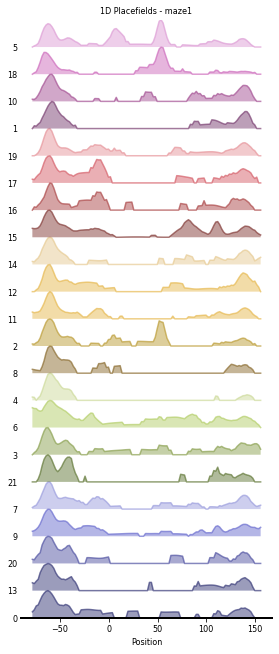

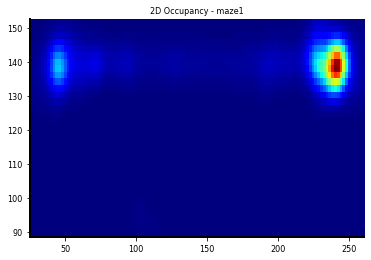

Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Occupancy - maze1.pdf"...
	 done.
Saving 2D Placefield image out to "output\2006-6-07_11-26-53\maze1\2D Placefields - maze1.pdf"...
	 done.
good_placefield_neuronIDs: [ 2  3  4  5  7  9 11 12 17 18 21 22 23 24 27 28 29 33 34 38 39 42 44 45
 46 47 48 53 55 57 58]; (31 good)


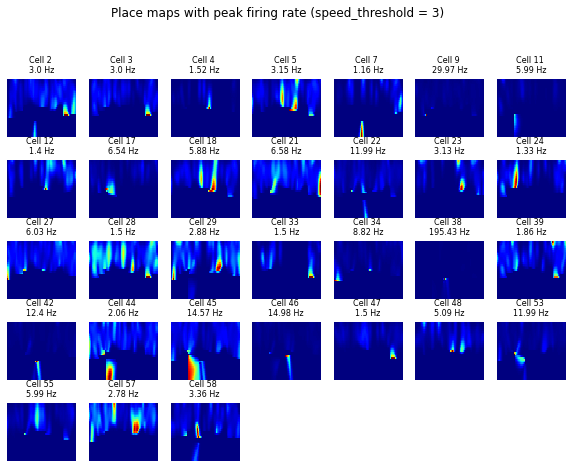

In [ ]:
from neuropy.analyses import Pf1D, Pf2D, perform_compute_placefields, plot_all_placefields
from neuropy.plotting.spikes import get_neuron_colors

should_force_recompute_placefields = True
should_display_2D_plots = True
# Setup the placefield computation config
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=3, grid_bin=2, smooth=2)

def compute_placefields_as_needed(active_epoch_placefields1D = None, active_epoch_placefields2D = None, should_force_recompute_placefields=False, should_display_2D_plots=False):
    active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_epoch_session.neurons, active_epoch_session.position, active_config.computation_config, active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True)
    # Plot the placefields computed and save them out to files:
    if should_display_2D_plots:
        ax_pf_1D, occupancy_fig, active_pf_2D_figures = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config)
    else:
        print('skipping 2D placefield plots')
    return active_epoch_placefields1D, active_epoch_placefields2D
        
try: active_epoch_placefields1D
except NameError: active_epoch_placefields1D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
try: active_epoch_placefields2D
except NameError: active_epoch_placefields2D = None # Checks variable active_epoch_placefields's existance, and sets its value to None if it doesn't exist so it can be checked in the next step

active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_as_needed(active_epoch_placefields1D, active_epoch_placefields2D, should_force_recompute_placefields=True, should_display_2D_plots=should_display_2D_plots)
    
# Focus on the 2D placefields:
active_epoch_placefields = active_epoch_placefields2D
# Get the cell IDs that have a good place field mapping:
good_placefield_neuronIDs = np.array(active_epoch_placefields.ratemap.neuron_ids) # in order of ascending ID
print('good_placefield_neuronIDs: {}; ({} good)'.format(good_placefield_neuronIDs, len(good_placefield_neuronIDs)))

## Filter by neurons with good placefields only:
active_epoch_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])
# active_epoch_session_Neurons = active_epoch_session.neurons

## Plotting Colors:
def build_units_colormap(session):
    pf_sort_ind = np.array([int(i) for i in np.arange(len(session.neuron_ids))]) # convert to integer scalar array
    pf_colors = get_neuron_colors(pf_sort_ind) # [4 x n_neurons]: colors are by ascending index ID
    pf_colormap = pf_colors.T # [n_neurons x 4] Make the colormap from the listed colors, used seemingly only by 'runAnalysis_PCAandICA(...)'
    pf_listed_colormap = ListedColormap(pf_colormap)
    return pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap


pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(active_epoch_session)
active_config.plotting_config.pf_sort_ind = pf_sort_ind
active_config.plotting_config.pf_colors = pf_colors
active_config.plotting_config.active_cells_colormap = pf_colormap
active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)


In [9]:
## ICA and PCA Analysis
should_show_2D_ICA_plots = False
from PhoPositionalData.analysis.neuronal_dimensionality_reduction import runAnalysis_PCAandICA
active_session_ensembles, template, zsc_template, pca_data = runAnalysis_PCAandICA(active_epoch_session.neurons, bin_size=0.250, frate_thresh=0.1, should_plot=should_show_2D_ICA_plots, active_cells_colormap=active_config.plotting_config.active_cells_colormap)

Based on frate_thresh, excluded neuron_ids: [ 4  7 11 33 47]


In [10]:
active_epoch_session.spikes_df

,t,shank,cluster,aclu,qclu,cluinfo,x,y,speed,traj,lap,cell_type,t_seconds,flat_spike_idx,x_loaded,y_loaded,linear_pos,unit_id
1,161,8,13,53,4,"(0, 0, 4, 4)",103.713582,100.743696,11.240502,0,-1,NeuronType.PYRAMIDAL,0.0161,1,NaN,NaN,NaN,51
37,2723,7,10,45,4,"(0, 0, 4, 0)",101.029778,98.370317,11.419917,0,-1,NeuronType.PYRAMIDAL,0.2723,37,0.374502,0.338421,NaN,43
38,2830,7,10,45,4,"(0, 0, 4, 0)",100.954521,98.273086,11.456236,0,-1,NeuronType.PYRAMIDAL,0.2830,38,0.374502,0.338421,NaN,43
42,2940,7,10,45,4,"(0, 0, 4, 0)",100.876573,98.172379,11.501605,0,-1,NeuronType.PYRAMIDAL,0.2940,42,0.374502,0.338421,NaN,43
51,3696,7,10,45,4,"(0, 0, 4, 0)",100.341850,97.481532,11.517768,0,-1,NeuronType.PYRAMIDAL,0.3696,51,0.374502,0.338421,NaN,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268637,17386079,10,3,57,2,"(0, 0, 1, 3)",216.823527,136.190318,8.575368,13,-1,NeuronType.PYRAMIDAL,1738.6079,268637,0.868184,0.476945,NaN,55
268690,17390228,7,10,45,4,"(0, 0, 4, 0)",211.450215,138.697046,15.366294,13,-1,NeuronType.PYRAMIDAL,1739.0228,268690,0.866364,0.475073,NaN,43
268692,17390449,7,10,45,4,"(0, 0, 4, 0)",211.118337,138.772197,15.382068,13,-1,NeuronType.PYRAMIDAL,1739.0449,268692,0.866335,0.475049,NaN,43
268695,17390532,8,13,53,4,"(0, 0, 4, 4)",210.993601,138.800442,15.396357,13,-1,NeuronType.PYRAMIDAL,1739.0532,268695,0.866324,0.475039,NaN,51


## Laps

In [16]:
# active_sess_laps_bak = sess.laps
active_epoch_session.laps = sess.laps
# active_epoch_session.flattened_spiketrains.spikes_df
# active_epoch_session.laps
# active_epoch_session.laps.lap_start_stop_time goes from 190.4446 to 5607.2581, and looks like it would match the value on my "curr_i" slider in the plotter if I multiplied it by 10, as the max value on the plotter is "57912.00"
# Plotter's slider: "57912.00": curr_i: 57265, t_start: 1910.79, t_stop: 1920.74. Note the slider fails to update at the end, so curr_i is probably a full value.
active_epoch_session.laps.lap_start_stop_slider_values = active_epoch_session.laps.lap_start_stop_time * 10.0
# active_epoch_session.laps

In [17]:
active_sess_laps = active_epoch_session.laps
print('active_epoch_session.laps.n_laps: {}'.format(active_epoch_session.laps.n_laps))
# print('active_sess_laps: {}'.format(active_sess_laps))
active_sess_laps.lap_start_stop_time # [  96.0589, 6223.86  ], [ 190.4446, 6285.0087], ... these values look like 't' format, not 't_seconds'
# active_sess_laps.laps_spike_counts
# active_sess_laps.lap_start_stop_flat_idx
def get_lap_flat_indicies(lap_id):
    start_stop = active_sess_laps.lap_start_stop_flat_idx[lap_id,:] # array([ 15841., 900605.]) the start_stop time for the first lap
    return start_stop[0], start_stop[1]

def get_lap_times(lap_id):
    start_stop = active_sess_laps.lap_start_stop_time[lap_id,:] # array([ 886.4489000000001, 931.6386]) the start_stop time for the first lap
    return start_stop[0], start_stop[1]

def build_lap_specific_lists(active_epoch_session):
    # Group by the lap column:
    lap_grouped_spikes_df = active_epoch_session.flattened_spiketrains.spikes_df.groupby(['lap']) #  as_index=False keeps the original index
    
    lap_specific_subsessions = list()
    lap_specific_dataframes = list()
    lap_spike_indicies = list()
    lap_spike_t_seconds = list()
    for i in np.arange(active_epoch_session.laps.n_laps):
        curr_lap_id = active_epoch_session.laps.lap_id[i]
        #curr_flat_cell_indicies = (flat_spikes_out_dict['aclu'] == active_epoch_placefields1D, active_epoch_placefields2D) # the indicies where the cell_id matches the current one
        # print('curr_lap_id: {}'.format(curr_lap_id))
        if curr_lap_id in lap_grouped_spikes_df.groups.keys():
            curr_lap_dataframe = lap_grouped_spikes_df.get_group(curr_lap_id)
            lap_specific_dataframes.append(curr_lap_dataframe)
            lap_spike_indicies.append(curr_lap_dataframe.flat_spike_idx.values)
            lap_spike_t_seconds.append(curr_lap_dataframe.t_seconds.values)
            lap_specific_subsessions.append(active_epoch_session.time_slice(curr_lap_dataframe.t_seconds.values[0], curr_lap_dataframe.t_seconds.values[-1]))
        else:
            # curr_lap_dataframe = pd.DataFrame()
            lap_specific_dataframes.append([])
            lap_spike_indicies.append([])
            lap_spike_t_seconds.append([])
            lap_specific_subsessions.append(None)
        # curr_lap_spike_indicies = curr_lap_dataframe.flat_spike_idx.values
        # lap_spike_indicies.append(curr_lap_dataframe.flat_spike_idx.values)
        # spiketrains.append(curr_cell_dataframe[time_variable_name].to_numpy())
        # shank_ids[i] = curr_cell_dataframe['shank'].to_numpy()[0] # get the first shank identifier, which should be the same for all of this curr_cell_id
        # cell_quality[i] = curr_cell_dataframe['qclu'].mean() # should be the same for all instances of curr_cell_id, but use mean just to make sure
        # cell_type.append(curr_cell_dataframe['cell_type'].to_numpy()[0])
    return lap_specific_subsessions, lap_specific_dataframes, lap_spike_indicies, lap_spike_t_seconds
        
    
    
# curr_lap_id = 4
# curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
# print('lap[{}]: ({}, {})'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop))
print('lap_ids: {}'.format(active_epoch_session.laps.lap_id))
lap_specific_subsessions, lap_specific_dataframes, lap_spike_indicies, lap_spike_t_seconds = build_lap_specific_lists(active_epoch_session)
# print('lap_spike_indicies: {}'.format(lap_spike_indicies))
# lap_spike_indicies[4] # all spike indicies that occured within the lap
# sess.laps.n_laps
# lap_specific_dataframes[4]
# lap_specific_subsessions[4].position.traces
# np.shape(lap_specific_subsessions[4].position.traces) # (2, 1299)

active_epoch_session.laps.n_laps: 42
lap_ids: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Constraining to epoch with times (start: 96.27120000000001, end: 153.10500000000002)
Constraining to epoch with times (start: 190.5316, end: 220.6108)
Constraining to epoch with times (start: 298.53360000000004, end: 402.72990000000004)
Constraining to epoch with times (start: 403.10490000000004, end: 427.2926)
Constraining to epoch with times (start: 886.6108, end: 929.9599000000001)
Constraining to epoch with times (start: 982.3486, end: 1003.7444)


In [18]:
active_epoch_session.spikes_df

,t,shank,cluster,aclu,qclu,cluinfo,x,y,speed,traj,lap,cell_type,t_seconds,flat_spike_idx,x_loaded,y_loaded,linear_pos,unit_id,z_fixed
1,161,8,13,53,4,"(0, 0, 4, 4)",103.713582,100.743696,11.240502,0,-1,NeuronType.PYRAMIDAL,0.0161,1,NaN,NaN,NaN,51,1.1
37,2723,7,10,45,4,"(0, 0, 4, 0)",101.029778,98.370317,11.419917,0,-1,NeuronType.PYRAMIDAL,0.2723,37,0.374502,0.338421,NaN,43,1.1
38,2830,7,10,45,4,"(0, 0, 4, 0)",100.954521,98.273086,11.456236,0,-1,NeuronType.PYRAMIDAL,0.2830,38,0.374502,0.338421,NaN,43,1.1
42,2940,7,10,45,4,"(0, 0, 4, 0)",100.876573,98.172379,11.501605,0,-1,NeuronType.PYRAMIDAL,0.2940,42,0.374502,0.338421,NaN,43,1.1
51,3696,7,10,45,4,"(0, 0, 4, 0)",100.341850,97.481532,11.517768,0,-1,NeuronType.PYRAMIDAL,0.3696,51,0.374502,0.338421,NaN,43,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268637,17386079,10,3,57,2,"(0, 0, 1, 3)",216.823527,136.190318,8.575368,13,-1,NeuronType.PYRAMIDAL,1738.6079,268637,0.868184,0.476945,NaN,55,1.1
268690,17390228,7,10,45,4,"(0, 0, 4, 0)",211.450215,138.697046,15.366294,13,-1,NeuronType.PYRAMIDAL,1739.0228,268690,0.866364,0.475073,NaN,43,1.1
268692,17390449,7,10,45,4,"(0, 0, 4, 0)",211.118337,138.772197,15.382068,13,-1,NeuronType.PYRAMIDAL,1739.0449,268692,0.866335,0.475049,NaN,43,1.1
268695,17390532,8,13,53,4,"(0, 0, 4, 4)",210.993601,138.800442,15.396357,13,-1,NeuronType.PYRAMIDAL,1739.0532,268695,0.866324,0.475039,NaN,51,1.1


## Main Spike/Placemap plotting:

# Plot Placemaps on 3D Plot

## Tuning Curves 3D Plot:

In [125]:
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer
try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields, pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

Applying custom Pyvista theme.
done.
No open BackgroundPlotter
Creating a new BackgroundPlotter
num_curr_tuning_curves: 31


In [136]:
# def plot_placefields2D(pTuningCurves, active_placefields, pf_colors: np.ndarray, zScalingFactor=10.0, show_legend=False):

#     # .threshold().elevation()

#     curr_tuning_curves = active_placefields.ratemap.normalized_tuning_curves
#     # curr_tuning_curves[curr_tuning_curves < 0.1] = np.nan
#     curr_tuning_curves = curr_tuning_curves * zScalingFactor

#     num_curr_tuning_curves = len(curr_tuning_curves)
#     # Get the cell IDs that have a good place field mapping:
#     good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
#     tuningCurvePlot_x, tuningCurvePlot_y = np.meshgrid(active_placefields.ratemap.xbin_centers, active_placefields.ratemap.ybin_centers)

#     pdata_currActiveNeuronTuningCurve = pv.StructuredGrid(tuningCurvePlot_x, tuningCurvePlot_y, curr_active_neuron_tuning_Curve)
#     pdata_currActiveNeuronTuningCurve["Elevation"] = curr_active_neuron_tuning_Curve.ravel(order="F")
        
#     return pTuningCurves

# plot_placefields2D(pTuningCurves, active_epoch_placefields

# ipcDataExplorer.plots['spikes_pf_active']['cellID']

# only_active_colormap = ipcDataExplorer.active_config.plotting_config.active_cells_listed_colormap.copy()
# only_active_colormap
test_full_pc_data = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc']

# test_subset = test_full_pc_data.GetCellGhostArray()
# test_subset = test_full_pc_data.GetCellData() # vtkmodules.vtkCommonDataModel.vtkCellData
test_subset = test_full_pc_data[test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

test_subset = test_full_pc_data.GetGhostArray() # [test_full_pc_data['cellID'] == 55] # vtkmodules.vtkCommonDataModel.vtkCellData

In [140]:
# pActiveTuningCurvesPlotter.export_obj('export.obj')
# pActiveTuningCurvesPlotter.export_gltf('export.gltf')

ipcDataExplorer.update_placefield_spike_visibility([44], True) # seems to work

# test_subset
# test_subset

update_placefield_spike_visibility(active_original_cell_unit_ids: [44], active_is_visible: True)
	 active_original_cell_unit_ids: [44]
	 is_cell_included: [False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False]
hide_placefield_spikes(active_index: [44], should_invert: True)
	 num_mesh_cells: 122143, num_ghosts: 119931
	 updating plot!


In [127]:
ipcDataExplorer.gui['tuningCurveSpikeVisibilityCallbacks'][1](False)
# ipcDataExplorer.get_cell_index([2, 3])

update_placefield_spike_visibility(active_index: [30], active_is_visible: False)
found_cell_unit_IDs: [58]
is_cell_included: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True]
hide_placefield_spikes(active_index: [58], should_invert: False)
	 num_mesh_cells: 122143, num_ghosts: 0
	 updating plot!


In [110]:
mesh = ipcDataExplorer.plots_data['spikes_pf_active']['historical_spikes_pc'].cast_to_unstructured_grid()
# mesh.n_cells
mesh_unique_ids = np.unique(mesh['cellID'])
print('n_cells: {}'.format(mesh.n_cells)) # 122143
print('cellIDs of mesh: {}'.format(mesh_unique_ids))
# np.unique(mesh['cellID']) # array([ 0,  1,  2,  3,  5,  7,  9, 10, 15, 16, 19, 20, 21, 22, 25, 26, 27, 31, 32, 36, 37, 40, 42, 43, 44, 45, 46, 51, 53, 55, 56])
# ipcDataExplorer.hide_placefield_spikes([0,1,2,3], should_invert=True)
# ipcDataExplorer.hide_placefield_spikes([23,2,34], should_invert=True)

# ipcDataExplorer.hide_placefield_spikes([34], should_invert=True)
ipcDataExplorer.hide_placefield_spikes([38], should_invert=False)

n_cells: 122143
cellIDs of mesh: [ 0  1  2  3  5  7  9 10 15 16 19 20 21 22 25 26 27 31 32 36 37 40 42 43
 44 45 46 51 53 55 56]


In [15]:
# the list of spike times that occured for this cell:
i = 2
active_epoch_session.neurons.neuron_ids[i]
active_epoch_session.neurons.spiketrains[i]

# spikes_df = FlattenedSpiketrains.build_spike_dataframe(sess)


array([ 180.014 ,  727.0111,  750.2361,  895.6424,  895.6632,  955.5745,
        955.9052, 1065.913 , 1449.853 , 1457.8802, 1517.0413, 1517.1031,
       1517.207 , 1517.3312, 1517.3984, 1517.4235, 1517.5995, 1517.657 ,
       1517.683 , 1518.0055, 1518.3946, 1518.794 , 1518.8296, 1584.6525,
       1596.2191, 1596.2873, 1626.4292, 1652.6402, 1686.6264, 1689.8477,
       1689.8733, 1722.3375, 1722.3592])

## Interactive 3D Spike and Behavior Browser: 

In [21]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

active_epoch_pos.sampling_rate (Hz): 29.96976599553983
longer_spikes_window - curr_view_window_length_samples - 30689
recent_spikes_window - curr_view_window_length_samples - 299
Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter
[f] - Focus and zoom in on the last clicked point
shift+click - Drag to pan the rendering scene
ctrl+click - Rotate the scene in 2D


# Programmatically change the animal position trail:

In [14]:
def plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces):
    num_lap_samples = np.shape(curr_lap_position_traces)[1]
    lap_fixed_z = np.full_like(curr_lap_position_traces[0,:], 0.9)
    plot_name = 'lap_location_trail'
    # fade_values = ipspikesDataExplorer.params.active_trail_opacity_values
    # size_values = ipspikesDataExplorer.params.active_trail_size_values
    trail_fade_values = None
    size_values = None
    # trail_fade_values = np.linspace(0.0, 0.6, num_lap_samples)
    size_values = np.linspace(0.2, 0.6, num_lap_samples) # fade from a scale of 0.2 to 0.6
    ipspikesDataExplorer.perform_plot_location_trail(plot_name, curr_lap_position_traces[0,:], curr_lap_position_traces[1,:], lap_fixed_z,
                                                 trail_fade_values=trail_fade_values, trail_point_size_values=size_values,
                                                 render=True, color='red')

# def hide_lap_trajectory_path(ipspikesDataExplorer):
    



    
## ACTIVE: Laps and Spikes:

# def visually_indicate_current_lap(
curr_lap_id = 0

curr_lap_t_start, curr_lap_t_stop = get_lap_times(curr_lap_id)
curr_lap_subsession = lap_specific_subsessions[curr_lap_id]
curr_lap_dataframe = lap_specific_dataframes[curr_lap_id] # the subset dataframe for this lap
curr_lap_spike_t_seconds = curr_lap_dataframe.t_seconds
curr_lap_spike_indicies = lap_spike_indicies[curr_lap_id] # all spike indicies that occured within the lap
curr_lap_position_traces = curr_lap_subsession.position.traces # the animal positions that were traversed during this lap

curr_lap_num_spikes = len(curr_lap_spike_indicies)
print('lap[{}]: ({}, {}): {} spikes.'.format(curr_lap_id, curr_lap_t_start, curr_lap_t_stop, curr_lap_num_spikes))

test_flat_times = active_epoch_session.flattened_spiketrains.flattened_spike_times
print(test_flat_times)
    
plot_lap_trajectory_path(ipspikesDataExplorer, curr_lap_position_traces)
# curr_lap_t_start
## TODO: enable showing/hiding the spikes for this data range programmatically in InteractivePlaceCellDataExplorer. 
# ipspikesDataExplorer.
# curr_lap_spike_t_seconds
# curr_lap_spike_indicies
# active_epoch_session.flattened_spiketrains.spikes_df.t_seconds.values[curr_lap_spike_indicies] # index 145937 is out of bounds for axis 0 with size 19647

NameError: name 'get_lap_times' is not defined

In [18]:
renderWindow.SetWindowName('Test')
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_indicies, active_included_recent_only_indicies=curr_lap_spike_indicies) # index 145937 is out of bounds for axis 0 with size 19647
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds, active_included_recent_only_indicies=curr_lap_spike_t_seconds) # 
# ipspikesDataExplorer.on_programmatic_data_update(active_included_all_historical_indicies=curr_lap_spike_t_seconds.values, active_included_recent_only_indicies=curr_lap_spike_t_seconds.values) # 

NameError: name 'renderWindow' is not defined

In [ ]:
# ipspikesDataExplorer.spikes_main_historical.SetVisibility(0)

# ipspikesDataExplorer.spikes_main_historical.SetVisibility(1)
# bool(ipspikesDataExplorer.spikes_main_historical.GetVisibility())

ipspikesDataExplorer.toggle_plot_visibility('spikes_main_historical')
# toggle_visibility(ipspikesDataExplorer.spikes_main_historical)

In [ ]:
ipspikesDataExplorer.toggle_plot_visibility('lap_location_trail')

In [ ]:
# ipspikesDataExplorer.spikes_main_recent_only.SetVisibility(True)
toggle_visibility(ipspikesDataExplorer.spikes_main_recent_only)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_location_trail)

In [ ]:
# ipspikesDataExplorer.animal_location_trail.SetVisibility(0)
toggle_visibility(ipspikesDataExplorer.animal_current_location_point)

# Programmatically change the animals location point indicator:

In [22]:
# .GetPosition() returns the actor's position, which is usually (0.0, 0.0, 0.0), and does not relate to the actor's data points
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetPosition()
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetXRange() # (44.23604202270508, 245.9059600830078)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetYRange() # (135.27638244628906, 145.448974609375)
# print(curr_animal_point)
# curr_animal_point = ipspikesDataExplorer.animal_location_trail.GetZRange() # (1.100000023841858, 1.100000023841858)

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
print('curr_animal_point: {}'.format(curr_animal_point))
curr_animal_point # curr_animal_poin

# curr_animal_point = np.array([0, 0, 0])

# curr_animal_point = np.column_stack((self.x[active_window_sample_indicies], self.y[active_window_sample_indicies], self.z_fixed))
# ipspikesDataExplorer.on_programmatic_data_update(curr_animal_point=curr_animal_point)

curr_debug_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # (206.27755737304688, 140.15452575683594, 1.100000023841858)
ipspikesDataExplorer.perform_plot_location_point('debug_point_plot', curr_animal_point, color='r')

curr_animal_point = np.array(ipspikesDataExplorer.animal_location_trail.GetCenter()) # not updated
print('new curr_animal_point: {}'.format(curr_animal_point))

curr_animal_point: [153.07785416 138.83090973   1.10000002]
new curr_animal_point: [153.07785416 138.83090973   1.10000002]


In [ ]:
# ipspikesDataExplorer.flattened_spike_positions_list

active_epoch_session.flattened_spiketrains.time_slice(curr_lap_spike_t_seconds.values[0], curr_lap_spike_t_seconds.values[-1]).spikes_df

In [ ]:
curr_lap_dataframe

In [ ]:
active_epoch_session.time_slice